In [3]:
import random
import jiwer

import resource
import pickle
from resource import get_sentiment_lexicon

from textflint.common.settings import MODIFIED_MASK
from textflint.common.utils.word_op import swap
from textflint.generation.transformation import WordSubstitute
from textflint.generation.transformation.UT import Keyboard, Typos
from textflint.input.component.sample import UTSample
from utils import visualize_text_diff, Accent, TypoSwap, AddVowel
from torch.utils.data import DataLoader
import torch
import numpy as np
import pandas as pd
from allennlp.training.metrics import CategoricalAccuracy, Average


### Word Corruption Evaluation

In [221]:
# df

In [225]:
temp = df.groupby("index")['countM'].transform(lambda x: max(x))
temp

0       2.75
1       2.75
2       2.75
3       2.75
4       2.75
        ... 
8516    3.00
8517    3.00
8518    3.00
8519    3.00
8520    3.00
Name: countM, Length: 8521, dtype: float64

In [281]:
def get_result(
    dataset_name, model_name,
    ):
    with open(f'outputs/{dataset_name}_noisy.pickle', 'rb') as file:
        noisy_data = pickle.load(file)
    with open(f'outputs_local/{dataset_name}_{model_name}.pickle', 'rb') as file:
        examples = pickle.load(file)
    df = pd.DataFrame.from_dict( examples )
    #test_data = resource.datasets[dataset_name][0]['test']
    # print(df)
    print(len(noisy_data), max(df['index']))
    df['text'] = [noisy_data[index][1][f'x'] for index in df['index']]
    df['noisy_txt'] = [noisy_data[index][1][f'x_{noise_type}'] for index, noise_type in zip(df['index'], df['noise_type'])]
    
    if model_name not in ['bert-base-uncased', 'roberta-base', 'albert-base-v2'] :
        df['conf'] = df.apply(lambda example:  torch.nn.functional.softmax(example.logit, dim=0).tolist()[example.label], axis=1)
        df['conf_clean'] = df.apply(lambda example: torch.nn.functional.softmax(example.logit_clean, dim=0).tolist()[example.label], axis=1)
        df['pred'] = df.logit.map(lambda logit: torch.argmax(logit, dim=0).item())
        df['pred_clean'] =df.logit_clean.map(lambda logit: torch.argmax(logit, dim=0).item())
        df['correct'] = df.pred == df.label
        df['correct_clean'] = df.pred_clean == df.label
    df['countN'] = df['N_sets'].apply(lambda x: len(x[0]))
    return df


def evaluate(
    output_dir,
    dataset_name, 
    model_name='bert-base-uncased-SST-2', 
    acc=True, 
    mode = None,
    print_acc_sim_by_noise=False,
    seq_max_len=None,
    no_consistent_pred=False
    ):
    """ 
        ## return 
        df:  for classifiers, samples whose clean texts are correctly predicted and satisfy the seq_max_len
         for LM for sentiment lexicon, we return all the samples
    """
    with open(f'{output_dir}/{dataset_name}_noisy.pickle', 'rb') as file:
        noisy_data = pickle.load(file)
    noisy_data = dict(noisy_data)
    with open(f'{output_dir}/{dataset_name}_{model_name}.pickle', 'rb') as file:
        examples = pickle.load(file)

    df = pd.DataFrame.from_dict( examples )
    df['countN'] = df['N_sets'].apply(lambda x: len(x[0]))
    df['text'] = [noisy_data[index][f'x'] for index in df['index']]
    df['noisy_txt'] = [noisy_data[index][f'x_{noise_type}'] for index, noise_type in zip(df['index'], df['noise_type'])]
    
    # for seq_max_len
    valid_index = []
    if seq_max_len is not None:
        for index, data in noisy_data:
            if len(data['x']) < seq_max_len:
                valid_index.append(index)
        print('Valid Length: ', len(valid_index))
        df = df[[True if i in valid_index else False for i in df['index'] ]]

    # for intact word corruption
    if mode == 'intact':
        print('All noisy words: ', len(df))
        df = df[df.countO== 1][df.wcr1 == 1]
        print('Intact Word Corruption: ', len(df))
    elif mode == "partial":
        df = df[df.countO>=1][df.countN>0]
        df['countM_by_O'] = [cm/co for cm, co in zip(df['countM'], df['countO'])]
        df['countM_by_O_round'] = [round(cm/co) for cm, co in zip(df['countM'], df['countO'])]
    elif mode == "all":
        pass
    
    # no compound words
    if dataset_name == "sentiment-lexicon":
        df = df.iloc[[True if len(lst)==1 else False for lst in df['text'] ]]

    ax = df.plot.scatter( x='countM', y='cos_sim', c='blue', alpha=0.3 )
    ax = df.plot.scatter( x='countM_by_word_len', y='cos_sim', c='blue', alpha=0.3 )
    plt.show()

    if acc:
        if dataset_name != "sentiment-lexicon":
            df['conf'] = df.apply(lambda example:  torch.nn.functional.softmax(example.logit, dim=0).tolist()[example.label], axis=1)
            df['conf_clean'] = df.apply(lambda example: torch.nn.functional.softmax(example.logit_clean, dim=0).tolist()[example.label], axis=1)
            df['pred'] = df.logit.map(lambda logit: torch.argmax(logit, dim=0).item())
            df['pred_clean'] =df.logit_clean.map(lambda logit: torch.argmax(logit, dim=0).item())
            df['correct'] = df.pred == df.label
            df['correct_clean'] = df.pred_clean == df.label
            
            print('Clean Accuracy:', df['correct_clean'].mean(), f" for {len(df)} examples.")
            print('only keep rows of which clean text is correctly predicted in df' )
            df = df[df['correct_clean']==True]
            
            if no_consistent_pred:
                #  not include examples consistenct predictoins
                consistent_pred_index = []
                for i, group in df[['index', 'correct']].groupby(['index']):
                    if len(group.correct.unique())==1:
                        consistent_pred_index.append(list(group['index'])[0])
                df = df[~df['index'].isin(consistent_pred_index)]
            df = df.reset_index()
            
            print('Misclassification Rate:')
            # <0.3, 0.3 - 0.5, >0.5
            print(
                '<0.3:', 
                1- df[df["countM_by_word_len"]<0.3]['correct'].mean(),
                ' (cos_sim:', {df[df["countM_by_word_len"]<0.3]['cos_sim'].mean()}, ')'
                )
            max_val = 0.8
            print(
                f'0.3-{max_val}:', 
                1- df[df["countM_by_word_len"]>=0.3][df["countM_by_word_len"]<=max_val]['correct'].mean(),
                ' (cos_sim:', {df[df["countM_by_word_len"]>=0.3][df["countM_by_word_len"]<=max_val]['cos_sim'].mean()}, ')'
                )
            print(
                f'>{max_val}:', 
                1- df[df["countM_by_word_len"]>max_val]['correct'].mean(),
                ' (cos_sim:', {df[df["countM_by_word_len"]>max_val]['cos_sim'].mean()}, ')'
                )
            # print(
            #     'for samples with min countM:', 
            #     1- df.iloc[df.groupby("index")["countM"].idxmin()]['correct'].mean(),
            #     ' (cos_sim:', {df.iloc[df.groupby("index")["countM"].idxmin()]['cos_sim'].mean()}, ')'
            #     )
            # print(
            #     'for all samples:', 
            #     1-df['correct'].mean(),
            #     ' (cos_sim:', df['cos_sim'].mean(), ')')
            # print(
            #     'for samples with max countM:', 
            #     1-df.iloc[df.groupby("index")["countM"].idxmax()]['correct'].mean(),
            #     ' (cos_sim:',{df.iloc[df.groupby("index")["countM"].transform(lambda x:x.max()).idx()]['cos_sim'].mean()},')')

#         wcs1_round_dist = {}
#         for score in sorted(df['countM_round'].unique()):
#             examples = df[(df['countM_round'] == score)]
# 
#             print(f'Metric for {score}')
#             
#             if dataset_name != "sentiment-lexicon":
#                 print(  1-examples.correct.mean())
#                 print( 'conf:', df.conf.mean())
# 
#             wcs1_round_dist[score] =  len(examples)
# 
#         print('Score Distribution: ', wcs1_round_dist)
        
        if print_acc_sim_by_noise:          
            noiser_names = [k[2:] for k in noisy_data[0].keys() if k.startswith('x_')]
            for noise_type in noiser_names:
                if dataset_name != "sentiment-lexicon":
                    print(f'Misclassification Rate for {noise_type}: ', 1-df[df.noise_type==noise_type].correct.mean())
                print(f'avg sim for {noise_type}: ', df[df.noise_type==noise_type].cos_sim.mean())

    else: # evaluating word corruption
        
        noiser_names = [k[2:] for k in noisy_data[0].keys() if k.startswith('x_')]
        print(noiser_names)
        for noise_type in noiser_names:
            print(f'avg countM for {noise_type}: ', df[df.noise_type==noise_type]['countM'].mean())
            print(f'avg countO for {noise_type}: ', df[df.noise_type==noise_type]['countO'].mean())
            print(f'avg countM_by_word_len for {noise_type}: ', df[df.noise_type==noise_type]['countM_by_word_len'].mean())
            print(f'avg wcr1 for {noise_type}: ', df[df.noise_type==noise_type]['wcr1'].mean())
            # print(f'avg wcr2 for {noise_type}: ', df[df.noise_type==noise_type]['wcr2'].mean())

    return df


All noisy words:  1552
Intact Word Corruption:  700


/home/xinzhel/.pyenv/versions/3.7.9/envs/allennlp-dev/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


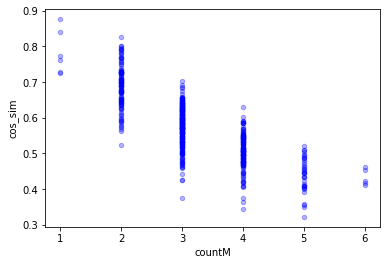

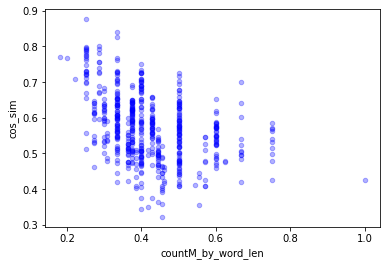

['keyboard', 'typoswap', 'accent', 'addvowel', 'deletevowel']
avg countM for keyboard:  3.410958904109589
avg countO for keyboard:  1.0
avg countM_by_word_len for keyboard:  0.4555271592942826
avg wcr1 for keyboard:  1.0
avg countM for typoswap:  3.390625
avg countO for typoswap:  1.0
avg countM_by_word_len for typoswap:  0.41797750860250865
avg wcr1 for typoswap:  1.0
avg countM for accent:  nan
avg countO for accent:  nan
avg countM_by_word_len for accent:  nan
avg wcr1 for accent:  nan
avg countM for addvowel:  3.306122448979592
avg countO for addvowel:  1.0
avg countM_by_word_len for addvowel:  0.43940048991069397
avg wcr1 for addvowel:  1.0
avg countM for deletevowel:  2.748299319727891
avg countO for deletevowel:  1.0
avg countM_by_word_len for deletevowel:  0.36170290404984284
avg wcr1 for deletevowel:  1.0


In [282]:
output_dir = "outputs_local_single_noise"
dataset_name = "sentiment-lexicon"
model_name = 'bert-base-uncased'
seq_max_len=None
# Evaluate tokenizers via WCR
# df = evaluate(dataset_name = dataset_name, model_name=model_name, acc=False)

# Evaluate PLMs via accuracy and cosine similarity
# Evaluating PLMs
df = evaluate(
    output_dir = output_dir,
    dataset_name = dataset_name, 
    model_name=model_name, 
    acc=False, 
    mode="intact", 
    seq_max_len=seq_max_len, 
    no_consistent_pred=False,
    print_acc_sim_by_noise=True)


In [196]:
df.columns

Index(['level_0', 'index', 'label', 'noise_type', 'countM',
       'countM_by_word_len', 'countM_round', 'countM_by_word_len_round',
       'countO', 'countO_round', 'wcr1', 'wcr2', 'cos_sim', 'logit',
       'logit_clean', 'O_sets', 'M_sets', 'N_sets', 'countN', 'text',
       'noisy_txt', 'conf', 'conf_clean', 'pred', 'pred_clean', 'correct',
       'correct_clean'],
      dtype='object')

In [129]:
# Outlier analysis
# select = df[df['cos_sim'] > 0.7][df['countM']==2]
# print(f'Select {len(select)} examples')
# for cos_sim, example,noisy_txt, M_set, O_set in zip(select['cos_sim'], select['text'],select['noisy_txt'], select['M_sets'], select['O_sets']):
#     # print 
#     print(round(cos_sim,2))
#     print( example)
#     print(' '.join(noisy_txt))
#     print(M_set)
#     print(O_set)
# 
# 
# for cos_sim, example,noisy_txt, M_set, O_set in zip(select['cos_sim'], select['text'],select['noisy_txt'], select['M_sets'], select['O_sets']):
#     # print 
#     print(round(cos_sim,2))
#     print( example)
#     print(' '.join(noisy_txt))
#     print(M_set)
#     print(O_set)



In [127]:
# Word corruption: N set is empty; |O| is 1
# correlate with |M|
df = df[df['wcr1'] >= 1][df['wcr2'] >= 1] 
df = df[df.countO == 1]
# df['countM_by_O'] = [cm/co for cm, co in zip(df['countM'], df['countO'])]
# df[df.countM==2.5]
# df_copy.groupby('countM').mean()
# ax = df_copy.plot.scatter( x='countM_by_O', y='cos_sim', c='DarkBlue' )
# plt.show()

### Analyzing the results

In [65]:

import matplotlib.pyplot as plt
import seaborn as sns
# The vulnerability of BPE tokenizers
# print(resource.hf_tokenizers['bert'].tokenize('transform'))
# print(resource.hf_tokenizers['bert'].tokenize('transformerify'))
# print(resource.hf_tokenizers['bert'].tokenize('transformer'))
# print(resource.hf_tokenizers['roberta'].tokenize('transform'))
# print(resource.hf_tokenizers['roberta'].tokenize('transformerify'))
# print(resource.hf_tokenizers['roberta'].tokenize('transformer'))
# print(resource.hf_tokenizers['albert'].tokenize('transform'))
# print(resource.hf_tokenizers['albert'].tokenize('transformerify'))
# print(resource.hf_tokenizers['albert'].tokenize('transformer'))

# the sizes of agreement sets
# dataset_name = "sentiment-lexicon"
# model_name = 'roberta-base'
# df = get_result(dataset_name, model_name)
# df['countN'] = df['N_sets'].apply(lambda x: len(x[0]))
# df['countN'].mean()
# 'albert-base-v2': 0.15
# bert-base-uncased: 0.12
# roberta-base: 0.51

# Minimum Functional Text
# import checklist
# from checklist.editor import Editor
# from checklist.perturb import Perturb
# with open(f"outputs/sentiment-lexicon_noisy.pickle", 'rb') as f:
#     noisy_data = pickle.load(f)
# assert len(noisy_data) == 200
# pos_lexicon, neg_lexicon = noisy_data[:100], noisy_data[100:]
# editor = Editor()
# editor.add_lexicon('pos', pos_lexicon)
# editor.add_lexicon('neg', neg_lexicon)
# mft_pos_examples = editor.template('This is {pos}', labels = 1,)
# mft_neg_examples = editor.template('This is {neg}', labels = 0, )
# mft_data = mft_pos_examples.data
# mft_data.extend(mft_neg_examples.data)
# mft_labels = mft_pos_examples.labels
# mft_labels.extend(mft_neg_examples.labels)

400 199
total size:  981
total size:  109
total size:  63
1.0 : 3
1.5 : 2
2.0 : 15
2.5 : 6
3.0 : 25
4.0 : 10
5.0 : 2
[]


/home/xinzhel/.pyenv/versions/3.7.9/envs/allennlp-dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


ValueError: List of boxplot statistics and `positions` values must have same the length

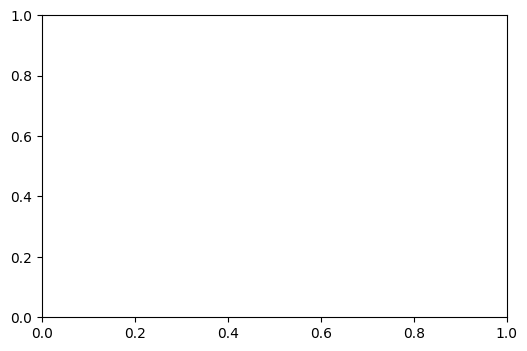

In [126]:

dataset_name = "sentiment-lexicon"
model_name = 'roberta-base'
seq_max_len=None
df = get_result(dataset_name, model_name)
print('total size: ', len(df))
df = df[df.countO== 1][df.wcr1 == 1]
print('total size: ', len(df))
df = df.iloc[[True if len(lst)==1 else False for lst in df['text'] ]]
print('total size: ', len(df))

fig = plt.figure( figsize=(6, 4), dpi=100 )
ax = fig.add_subplot(1,1,1)
groups = df.groupby('countM')['cos_sim']
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
bert_sim_by_m_scores = []
ticks = []
for name, group in groups:
    print(name, ':', len(group.values))
    if len(group.values) < 30:
        continue
    ticks.append(int(name))
    bert_sim_by_m_scores.append(group.values)
    
print(ticks)
bpl = ax.boxplot(bert_sim_by_m_scores, sym='', positions=range(0, len(ticks), 1), widths=0.3)
set_box_color(bpl, '#000000') # colors are from http://colorbrewer2.org/
ax.set_xticks(range(0, len(ticks), 1), ticks)
ax.set_xlabel('M_score')
ax.set_ylabel('Similarity')
# ax.set_ylim(0, 1)
# ax.set_xlim(0, 5)
plt.show()
# positions=np.array(range(len(bert_sim_by_m_scores)))*2


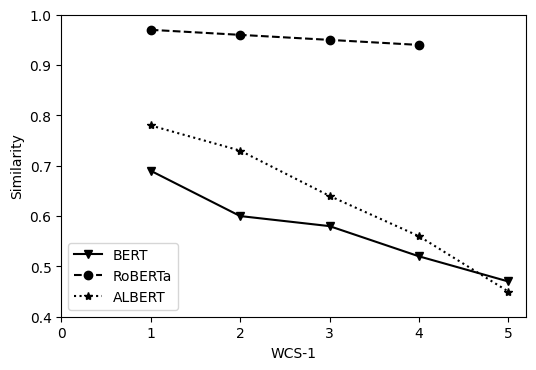

In [32]:

# sentiment-lexicon-sim
result = {
    'BERT': {1: 0.69, 2: 0.60, 3: 0.58, 4: 0.52, 5: 0.47}, 
    'RoBERTa': {1:0.97,2:0.96,3:0.95,4:0.94},
    'ALBERT': {1:0.78, 2:0.73, 3:0.64, 4:0.56, 5:0.45}
    }

# sst2-sim
# result = {
#     'BERT': {2: 0.52, 3: 0.50, 4: 0.48}, 
#     'RoBERTa': {1:0.56, 2:0.54, 3:0.53},
#     'ALBERT': { 2:0.64, 3:0.57, 4: 0.51}
#     }


# ag-news-sim
# result = {
#     'BERT': {2: 0.87, 3: 0.86, 4: 0.84}, 
#     'RoBERTa': {1:0.52,2:0.56,3:0.54,4:0.58},
#     'ALBERT': { 2:0.75, 3:0.75, 4: 0.74}
#     }

fig = plt.figure( figsize=(6, 4), dpi=100 )
ax = fig.add_subplot(1,1,1)
ax.plot(result['BERT'].keys(), result['BERT'].values(), color='black', linewidth=1.5, linestyle='-', marker='v', label='BERT')
ax.plot(result['RoBERTa'].keys(), result['RoBERTa'].values(), color='black', linewidth=1.5, linestyle='--', marker='o', label='RoBERTa')
ax.plot(result['ALBERT'].keys(), result['ALBERT'].values(), color='black', linewidth=1.5, linestyle=':', marker='*', label='ALBERT')
plt.xticks(np.linspace(0, 5, 6))
plt.yticks(np.linspace(0.4, 1, 7))
ax.set_ylim(0.4,1)
ax.set_xlabel('WCS-1')
ax.set_ylabel('Similarity')
plt.legend(loc='best', frameon=True)
plt.show()


In [ ]:

# sst2-acc
# result = {
#     'BERT': {2: 1-0.68, 3: 1-0.65, 4: 1-0.62}, 
#     'RoBERTa': {1:1-0.76, 2:1-0.74, 3:1-0.71},
#     'ALBERT': { 2:1-0.72, 3:1-0.69, 4: 1-0.66}
#     }

# ag-news-acc
# result = {
#     'BERT': {2: 1-0.91, 3: 1-0.91, 4: 1-0.90}, 
#     'RoBERTa': {1:1-0.66,2:1-0.74,3:1-0.71,4:1-0.74},
#     'ALBERT': { 2:1-0.91, 3:1-0.91, 4: 1-0.90,}
#     }


fig = plt.figure( figsize=(6, 4), dpi=100 )
ax = fig.add_subplot(1,1,1)
ax.plot(result['BERT'].keys(), result['BERT'].values(), color='black', linewidth=1.5, linestyle='-', marker='v', label='BERT')
ax.plot(result['RoBERTa'].keys(), result['RoBERTa'].values(), color='black', linewidth=1.5, linestyle='--', marker='o', label='RoBERTa')
ax.plot(result['ALBERT'].keys(), result['ALBERT'].values(), color='black', linewidth=1.5, linestyle=':', marker='*', label='ALBERT')
plt.xticks(np.linspace(0, 5, 6))
plt.yticks(np.linspace(0, 0.4, 5))
ax.set_ylim(0,0.5)
ax.set_xlabel('WCS-1')
ax.set_ylabel('Misclassification Rate')
plt.legend(loc='best', frameon=True)
plt.show()
# for acc
ax.set_ylim(0,5)
ax.set_ylim(0.6,0.93)



In [5]:
import pickle
dataset_name = 'ag_news'
with open(f"outputs/{dataset_name}_noisy.pickle", 'rb') as file:
    samples = pickle.load(file)

visualize_text_diff(' '.join(samples[1][1]['x']), ' '.join(samples[1][1]['x_keyboard']), color_method='html')

("Peru <font color = blue>Gov't</font> : <font color = blue>Police</font> <font color = blue>Killed</font> in Self - Defense Peru 's interior minister <font color = blue>said</font> Wednesday that police acted in self - <font color = blue>defense</font> when they killed three <font color = blue>coca</font> farmers who were part of a group that hurled rocks and tried to burn a police <font color = blue>lieutenant</font> alive to protest U.S.-backed eradication of their <font color = blue>cocaine</font> <font color = blue>producing</font> <font color = blue>crop</font> .",
 "Peru <font color = purple>GoB't</font> : <font color = purple>PoPice</font> <font color = purple>KillSd</font> in Self - Defense Peru 's interior minister <font color = purple>sald</font> Wednesday that police acted in self - <font color = purple>dDfense</font> when they killed three <font color = purple>cocS</font> farmers who were part of a group that hurled rocks and tried to burn a police <font color = purple>lie

In [ ]:
def get_result(example, y):
    result = dict()
    device = next(model.parameters()).device
    label = torch.LongTensor([y]).unsqueeze(0).to(device)
    for k, v in example.items():
        if k.startswith('x'):
            X = tokenizer.encode_plus(v, return_tensors='pt')
            X = {k: v.to(device) for k, v in X.items()}
            model_output = model(**X, labels=label)
            result['logits_'+k[2:]] = model_output['logits']
    return result

get_result(example, y)